## Векторные представления слов

Векторные представления слов (или embeddings) - это наборы чисел, которые должны как-то отражать смысл/значение слов. Формально значение определить очень сложно, поэтому в NLP используются очень упрощенные и утилитарные подходы к пониманию значения. Например, можно считать, что векторные представления хорошо передают смысл слов, если близость (по какой-то выбранной метрике) между похожими словами большая, а между противоположными - большая. Другой пример - с помощью векторных представлений получается хорошо решить задачу, которая требует понимания смысла (т.е. почти любую NLP задачу), значит эти векторные представления хорошо кодируют смысл. 

Есть еще такие тонкости как многозначность и зависимость смысла от контекста, но это уже сильно сложнее и мы оставим их на следующие семинары, а пока просто полностью проигнорируем. К тому же, как и с мешком слов, часто упрощенного подхода будет достаточно.

Единственная окололингвистическая теоретическая часть, о которой стоит сказать это дистрибутивная гипотеза. Она состоит в том, что лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения. Обычно в научных статьях цитируют John Firth (Ферс) - '*You shall know a word by the company it keeps*' (Firth, J. R. 1957:11) 
Также в "Филосовских исследованиях" Витгенштейна есть такое -  *“For a large class of cases—though not for all—in which we employ the word ‘meaning’ it can be defined thus: **the meaning of a word is its use in the language.**”* (1951)

Саму область иногда называют дистрибутивная семантика.

Давайте посмотрим, как можно строить векторные представления слов.

In [7]:
%pip install matplotlib pandas scikit-learn
# %pip install --upgrade keras
%pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 7.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 12.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Torch version:", torch.__version__)

Using device: cuda
Torch version: 2.2.1


### Матричные разложения 

Для начала вспомним матричные разложения. В двух методах, которые мы использовали для тематического моделирования одна из матриц была размерности (количество слов в словаре, количество тем), т.е. каждую строчку в этой матрице можно рассматривать как векторное представление слова! Давайте разложим матрицу документы-слова, собранную по википедии и посмотрим на близость векторов слов.

# на картинке TruncatedSVD
![](https://miro.medium.com/max/1362/1*AQ3ohYYQtJLIGWOc5UBrDQ.webp)

In [6]:
# в нашем корпусе 20к текстов
wiki = open('wiki_data.txt').read().split('\n')

In [11]:
len(wiki)

20003

In [12]:
cv = CountVectorizer(max_features=10000)
svd = TruncatedSVD(200)

X = cv.fit_transform(wiki)
X_svd = svd.fit_transform(X)

Получившаяся матрица X нас не интересует. Нам нужно вытащить матрицу U, она лежит в svd.components_

In [13]:
# изначально U размерности (темы, слова) и для удобства ее нужно перевернуть - транспонировать
embeddings = svd.components_.T

In [14]:
embeddings.shape

(10000, 200)

Теперь вытаскиваем соответствия слов индексам и наоборот

In [15]:
id2word = cv.get_feature_names_out()
word2id = {word:i for i,word in enumerate(id2word)}

In [16]:
word2id['птица']

7074

Напишем простую функцию, которая для заданного слова найдет ближайшие ему слова в матрице

In [17]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

Испытаем ее на нескольких рандомных словах

In [18]:
most_similar('птица', embeddings)

['птица',
 'самцы',
 'самцов',
 'птицы',
 'самки',
 'самка',
 'самок',
 'питается',
 'пятнами',
 'обитает']

In [19]:
most_similar('церковь', embeddings)

['церковь',
 'чудотворца',
 'каменная',
 'прихожан',
 'храм',
 'деревянная',
 'богослужения',
 'храма',
 'орла',
 'закрыта']

In [20]:
most_similar('москва', embeddings)

['москва',
 'выставка',
 'арт',
 'центральный',
 'галерея',
 'выставке',
 'выставках',
 'галерее',
 'художника',
 'постоянная']

Кажется, что получается неплохо. 

Но матричные разложения для этой задачи обычно не применяют. Основной метод для создания векторых представлений слов - это word2vec и его улучшение fastext. 

## Word2Vec

Word2Vec был создан в 2013 году в Google командой под руководством Tomas Mikolov. 

Он был описан в двух статьях: 
1) https://arxiv.org/abs/1301.3781 (https://papers.nips.cc/paper_files/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html)   
2) https://aclanthology.org/N13-1090/

С word2vec началась transfer learning и self supervised революция в NLP. Вместо обучения моделей с нуля под каждую конкретную задачу люди стали предобучать общие модели на сыром тексте и затем дообучать их под нужные задачи, используя размеченные данные.  У такого подхода сразу несколько преимуществ: 1) он просто лучше работает, так как помимо самих размеченных данных, модель косвенно использует большое количество знаний из предобучающего корпуса; 2) размеченных данных нужно сильно меньше (для достижения качества сопостовимого с моделью обученной с нуля), так как предобученной модели не нужно выучивать базовое понимание языка, она сразу может фокусироваться на специфичных для задачи паттернах; 3) одну предобученную модель можно переиспользовать в разных задачах (часто такие модели создаются крупными компаниями/лабами с огромными вычислительными ресурсами, а затем выкладываются в открытый доступ) . 

Также важным достоинством самого word2vec была его эффективность (и по скорости и по потреблению ресурсов), что с одной строны позволило большим компаниям обучить модели на огромных корпусах, а с другой дало возможность отдельным исследователям строить качественные специфичные модели (например, на корпусе научных статей по математике), используя небольшие сервера или вообще личные компьютеры. 

Сейчас word2vec уже конечно устарел (но он может быть хорошим бейзлайном), транформерные модели лучше. Но через word2vec удобно начать переходить к нейронным сетям (так как это на самом деле однойслойная нейронка). Поэтому мы попробуем воспроизвести базовые составляющие алгоритма в keras, параллельно разобрав и основы deep learning. В Word2Vec очень много деталей и оптимизаций, которые мы опустим, при решении конкретной задачи лучше использовать готовую реализацию (ниже мы это сделаем через gensim).

### word2vec на коленке

Для начала нам нужно построить словарь.

Предобработка нам не так важна. Главное - получить из текстов токены.

In [21]:
import re
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

Лучше сразу посчитать количество упоминаний, чтобы отсеять самые редкие.

In [22]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

443к слов - это многовато

In [23]:
len(vocab)

443922

Возьмем только те, что встретились больше 30 раз.

In [24]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [25]:
len(filtered_vocab)

17016

~17к - уже нормальная цифра

Теперь нам нужно заменить в каждом тексте слова на числа (индексы в словаре). 

Создадим для этого специальный словарь с индексами. В этот словарь нам нужно положить дополнительный токен - PAD (чуть ниже станет понятнее)

In [26]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [27]:
id2word = {i:word for word, i in word2id.items()}

Заменяем слова на индексы.

In [28]:

sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [31]:
# sentences[:3]

Далее нужно преобразовать токенизированные тексты в формат для обучения.

Word2vec обучается решать синтетическую задачу, а точнее две зеркальные задачи - предсказывать слово по его окружению и предсказывать окружение по слову. 

У такой задачи есть какое-то теоретическое обоснование (см. выше про дистрибутивную гипотезу), но оно скорее для красоты - просто это работает. В более поздних моделях используются немного другие синтетические задачи - заполнение пропусков или просто генерация следующего слова.

Обучающие данные для таких задач можно просто гененировать из любого текста практически бесконечно, поэтому такой подход называется self-supervised.

Давайте разберем 2 алгоритма word2vec: skip gram и CBOW (continuos bag of words). В обоих алгоритмах происходит итерирование по кусочкам текстов фиксированной длинны (окнам). В каждом окне выбирается центральное целевое слово (target), а слова слева и справа от него считаются контекстом (context). 

**В Skip-gram по слову предсказывается окружение, а в CBOW по окружению предсказывается целевое слово.**

### Skip Gram

![](https://leimao.github.io/images/article/2019-08-23-Word2Vec-Classic/word2vec.png)

  Давайте соберем датасет для skip gram. Датасетом будут просто пары - (целевое слово, контекстное слово). 

In [32]:
# skip gram
X = []
y = []

window = 5
for sent in sentences[:1000]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        context = sent[max(0, i-window):i] + sent[i+1:i+window]  # context (слова до и после целевого)
        # в начале и в конце окно будет неполным, но это не страшно

        for context_word in context:
            X.append(word)
            y.append(context_word)


In [33]:
X[1], y[1]

(11884, 5912)

In [34]:
len(X), len(y)

(1765036, 1765036)

Как и в любой задаче машинного обучения нужно тестироваться на отложенной выборке

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

### Создаем нейронную сеть

Для введения в нейронные сети посмотрите:
1) серию видео на канале 3blue1brown - https://www.youtube.com/watch?v=aircAruvnKk  
2) лекцию курса dlcoure.ai - https://www.youtube.com/watch?v=kWTC1NvL894

Word2Vec можно рассматривать как очень маленькую нейронную сеть - тут всего 1 слой. Сама задача сводится к классификации. 

Стандартный подход к написанию нейронный сетей в pytorch - это создание специального класса в котором есть функция __init__ где определяются слои, и функция forward, где определяется как слои применяются к входным данным.

In [36]:
class SkipGramSoftmax(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)

        # И теперь 1 реальный слой, который называется полносвязным/линейным (fc = cокращение от fully connected)
        # Полносвязный слой это матрица, применение полносвязного слоя - это умножение на эту матрицу
        # На выходе получится вектор или матрица (по правилу умножения матриц, размерность в итоге будет - (n, m) * (m, k) = n*k)
        # В нашем случае n - это 1, так как у нас 1 вектор 1 целевого слова
        # m - должна матчится в обоих матрицах, в нашем случае это emb_dim
        # k - можно подбирать любой, но
        # в нашем случае мы хотим получить по 1 числу на 1 слово в словаре, т.е. нужно поставить k = размер словаря
        # это число будет соответствовать вероятности предсказания этого слова
        
        # умножение вектора на матрицу можно интепретировать как нахождение близости
        # с каждым элементом матрицы; т.е. мы берем эмбединг и находим близость с эмбедингами всех других слов в словаре
        
        self.fc = nn.Linear(emb_dim, vocab_size)

    def forward(self, x):
        """
        x: LongTensor (batch,)
        """
        e = self.emb(x)           # (batch, emb_dim)
        logits = self.fc(e)       # (batch, vocab_size)
        return logits

Для модели нужно задать лосс (функцию потерь), которая будет рассчитывать качество предсказаний на обучающих данных. 
Лосс зависит от задачи. Для классификации типичная функция потерь - кросс энтропия. 
Также для обучения нужен оптимизатор - он отвечает за обновления параметров при обучении. Пока что не будет углубляться в детали как и почему это так работает и пойдем дальше.

In [37]:
vocab_size = len(word2id)
emb_dim = 100

# одна из заметных особенностей pytroch это device api
# саму модели и обучающие данные нужно вручную отправлять на видеокарту/возвращаться на cpu
# одна из самых частых ошибок - несответствие девайсов двух матриц между которомы нужно сделать вычисления
model = SkipGramSoftmax(vocab_size, emb_dim).to(device)


# По умолчанию полносвязный слой не выдает вероятности (а выдает то что называется logits), 
# чтобы получить вероятности нужно использовать softmax
# Софтмакс - это одна из функций активации
# Функции аквтивации преобразуют числа каким-то нелинейным способом, которого не добьешься обычным умножением на матрицу
# сочетание линейных операций с матрицами и векторами и нелинейных функций - это то что делает нейронные сети такими мощными
# но в pytorch есть два класса для классификационных лоссов, CrossEntropyLoss и NLLLoss 
# первый ожидает logits (и сам сделает софтмакс внутри), а второй ожидает уже вероятности 
# в нашем случае у нас логиты и мы используем CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# выбираем оптимизатор - он влияет на то, как будет обновляться модель 
# (подробнее вот тут - 
# https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3 ).
# По умолчанию можно ставить adam и менять только learning_rate

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Теперь нужно задать обучающий данные. Мы уже сделали это выше но теперь нужно преобразовать это в Tensor формат, и обернуть в DataLoader, который будет подавать в модель куски обучающих данных (батчи)

In [38]:
X_train_t = torch.LongTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_valid_t = torch.LongTensor(X_valid)
y_valid_t = torch.LongTensor(y_valid)

train_ds = TensorDataset(X_train_t, y_train_t)
valid_ds = TensorDataset(X_valid_t, y_valid_t)


# размер батча зависит от размера нейронной сети и ресурсов
# обычно это значение от 4 до нескольких тысяч
train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=1000)

Последняя часть - это train loop. В pytorch по умолчанию нет дополнительных абстракций вроде fit() predict() и нужно просто написать цикл, который пройдется по данным и вызовет предсказания на каждом из батчей. Вызов model() внутри вызовет функцию forward, которую мы написали выше. criterion() рассчитает лосс на получившихся предсказниях, сравнив их с правильными ответами. Всю градиентную работу pytorch берет на себя (внутри он запишет все вычисления произведенные с данными внутри forward и criterion), но обновление весов модели вызывается вручную через .backward(). То есть цикл обучения это forward step, где к входным данным применяются текущие веса, и рассчитывается лосс, и backward step, где обновления весов расспространяются по всем слоям, которые участвовали в вычислениях на forward шаге.

По умолчанию все вызовы модели записываются и накапливаются к backward вызову. Если backward не вызывать, то сбрасываться это никак не будет и легко выйти за пределы доступных ресурсов. Иногда это нужно и можно, например, вызывать backward только на каждый 10 вызов forward (это называеся gradient accumulation). Но чаще всего градиенты просто не нужны и нужно перевести модель в eval mode, где градиенты не накапливаются. Самый базовый способ это сделать изменить .required_grad атрибут у весов в матрице, но есть еще контекст менеджеры вроде with torch.no_grad() которые просто сделают это для всего, что будет внутри контекста. 

In [39]:
num_epochs = 10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(train_ds)
    train_losses.append(epoch_loss)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            # нет backward степа!
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(valid_ds)
    valid_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {epoch_loss:.4f}, val loss: {val_loss:.4f}")

Epoch 1/10 - train loss: 8.3003, val loss: 7.6521
Epoch 2/10 - train loss: 7.4145, val loss: 7.4997
Epoch 3/10 - train loss: 7.2246, val loss: 7.4582
Epoch 4/10 - train loss: 7.1043, val loss: 7.4355
Epoch 5/10 - train loss: 7.0097, val loss: 7.4205
Epoch 6/10 - train loss: 6.9311, val loss: 7.4087
Epoch 7/10 - train loss: 6.8635, val loss: 7.4015
Epoch 8/10 - train loss: 6.8042, val loss: 7.3944
Epoch 9/10 - train loss: 6.7514, val loss: 7.3897
Epoch 10/10 - train loss: 6.7037, val loss: 7.3865


Посмотрим на графики функции потерь. Она должна уменьшаться и на трейне и на тесте

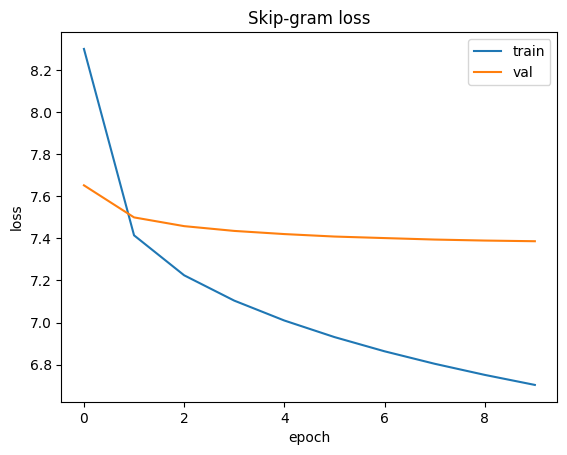

In [40]:
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Skip-gram loss')
plt.legend()
plt.show()

В нашей нейронной сети две матрицы с весами (embedding и fc слои). По размеру они одинаковые и сами эмбединги можно брать и из одной и из другой, а можно из даже усреднить

In [41]:
embeddings_1 = model.emb.weight.detach().cpu().numpy()               # (vocab_size, emb_dim)
embeddings_2 = model.fc.weight.detach().cpu().numpy()#.T            # (vocab_size, emb_dim)

embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

embeddings.shape

(17017, 100)

И также найти самый близкие слова

In [32]:
most_similar('церковь', embeddings)

['церковь',
 'иисуса',
 'собор',
 'снято',
 'сих',
 'сигнала',
 'деревянная',
 'реставрация',
 'латвийской',
 'иконы']

In [33]:
most_similar('слово', embeddings)

['слово',
 'заключается',
 'с',
 'распространён',
 'листьев',
 'условием',
 'удобства',
 'пациента',
 'внутри',
 'деятеля']

### CBOW


Теперь попробуем CBOW. В нем нужно по контексту предсказать целевое слово. В отличие от skip-gram тут сразу используется весь контекст, а векторы слов в контексте усредняются в 1 вектор контекста.

Собрать датасет очень просто. Но так как тут нам придется работать с последовательностями разной длины, то нужно ввести паддинг. Паддинг нужен чтобы сравнять все к одной длине (обрезав слишком длинные, или дополнив короткие 0 или каким-то другим значением)

In [42]:
import numpy as np

def pad_sequences(sequences, maxlen, padding='post', value=0):
    """
    sequences: list of lists (разной длины)
    возвращает np.array shape (len(sequences), maxlen)
    """
    res = np.full((len(sequences), maxlen), value, dtype='int64')
    for i, seq in enumerate(sequences):
        if not seq:
            continue
        if len(seq) >= maxlen:
            if padding == 'post':
                res[i] = np.array(seq[:maxlen])
            else:
                res[i] = np.array(seq[-maxlen:])
        else:
            if padding == 'post':
                res[i, :len(seq)] = np.array(seq)
            else:
                res[i, -len(seq):] = np.array(seq)
    return res

In [43]:
# пример паддинга
seq = [[1,2,3], [1,2], [1,2,3,4,5]]
pad_sequences(seq, 5, value=0)

array([[1, 2, 3, 0, 0],
       [1, 2, 0, 0, 0],
       [1, 2, 3, 4, 5]])

In [45]:
# cbow
X = []
y = []

window = 5
for sent in sentences[:10000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]
        X.append(context)
        y.append(word)

X = pad_sequences(X, maxlen=10, padding='post', value=0)
y = np.array(y, dtype='int64')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Единственной отличие в сети - это усреднение векторов в один контекстный вектор

In [44]:
class CBOWSoftmax(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.fc = nn.Linear(emb_dim, vocab_size)

    def forward(self, x):
        """
        x: LongTensor (batch, window_size)
        """
        e = self.emb(x)              # (batch, window, emb_dim)
        context_vec = e.sum(dim=1)   # (batch, emb_dim) 
        logits = self.fc(context_vec)
        return logits

Все остальное точно такое же

In [46]:
vocab_size = len(word2id)
emb_dim = 100

model = CBOWSoftmax(vocab_size, emb_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [47]:
X_train_t = torch.LongTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_valid_t = torch.LongTensor(X_valid)
y_valid_t = torch.LongTensor(y_valid)

train_ds = TensorDataset(X_train_t, y_train_t)
valid_ds = TensorDataset(X_valid_t, y_valid_t)

train_loader = DataLoader(train_ds, batch_size=1000, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=1000)

In [48]:
num_epochs = 20
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(train_ds)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(valid_ds)
    valid_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {epoch_loss:.4f}, val loss: {val_loss:.4f}")

Epoch 1/20 - train loss: 7.5408, val loss: 6.8709
Epoch 2/20 - train loss: 6.4418, val loss: 6.5711
Epoch 3/20 - train loss: 6.0908, val loss: 6.4608
Epoch 4/20 - train loss: 5.8865, val loss: 6.3959
Epoch 5/20 - train loss: 5.7374, val loss: 6.3499
Epoch 6/20 - train loss: 5.6172, val loss: 6.3158
Epoch 7/20 - train loss: 5.5146, val loss: 6.2922
Epoch 8/20 - train loss: 5.4243, val loss: 6.2699
Epoch 9/20 - train loss: 5.3428, val loss: 6.2519
Epoch 10/20 - train loss: 5.2685, val loss: 6.2410
Epoch 11/20 - train loss: 5.2003, val loss: 6.2305
Epoch 12/20 - train loss: 5.1369, val loss: 6.2240
Epoch 13/20 - train loss: 5.0782, val loss: 6.2193
Epoch 14/20 - train loss: 5.0232, val loss: 6.2170
Epoch 15/20 - train loss: 4.9716, val loss: 6.2176
Epoch 16/20 - train loss: 4.9232, val loss: 6.2184
Epoch 17/20 - train loss: 4.8772, val loss: 6.2213
Epoch 18/20 - train loss: 4.8341, val loss: 6.2274
Epoch 19/20 - train loss: 4.7935, val loss: 6.2338
Epoch 20/20 - train loss: 4.7548, val lo

In [49]:
embeddings_1 = model.emb.weight.detach().cpu().numpy()
embeddings_2 = model.fc.weight.detach().cpu().numpy()#.T
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

embeddings.shape

(17017, 100)

In [50]:
most_similar('церковь', embeddings)

['церковь',
 'часовня',
 'церкви',
 'икона',
 'алтарь',
 'екатерине',
 'посёлка',
 'собор',
 'иоанна',
 'могила']

### Negative sampling

Одна из основных оптимизаций в word2vec - negative sampling. Задача из многоклассовой классификации преобразуется в бинарную классификацию. На вход подается сразу и целевое слово и контекст, а на выходе ожидается вероятность того, что они употребляются вместе. Положительные примеры просто берутся из корпуса, а для того, чтобы собрать негативные примеры, из словаря просто случайно выбираются слова. Возможна ситуация, когда для контекста случайно выбранное слово на самом деле может встретиться в этом контексте, но за счет большого количества примеров, такие неточности не повлияют на итоговый результат.

В этот раз не будем сразу генерировать весь датасет. Он получается очень большой и эффективнее генерировать примеры на ходу (т.е. использовать генератор)

In [70]:
vocab_size = len(id2word)

Эта функция просто генерирует обучающее примеры батчами. В tf генераторы можно напрямую модавать в fit модели

In [40]:
def gen_batches_cbow(sentences, window=5, batch_size=1000):
    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) >= batch_size:
                    X_target_arr = np.array(X_target, dtype='int64')
                    X_context_arr = pad_sequences(X_context, maxlen=window, padding='post', value=0)
                    y_arr = np.array(y, dtype='float32')
                    yield (X_target_arr, X_context_arr), y_arr
                    X_target, X_context, y = [], [], []


В сети у нас будут два Embedding слоя для контекста и целевого слова, а полносвязного слоя даже не будет! Мы будет просто считать dot product (близость) между двумя векторами и на основе полученной близости делать предсказание

In [41]:
class CBOWNegSampling(nn.Module):
    def __init__(self, vocab_size, emb_dim, window_size):
        super().__init__()
        self.target_emb = nn.Embedding(vocab_size, emb_dim)
        self.context_emb = nn.Embedding(vocab_size, emb_dim)
        self.window_size = window_size

    def forward(self, target_ids, context_ids):
        """
        target_ids: (batch,)
        context_ids: (batch, window_size)
        """
        t = self.target_emb(target_ids)          # (batch, emb_dim)
        c = self.context_emb(context_ids)        # (batch, window, emb_dim)
        c_sum = c.sum(dim=1)                     # (batch, emb_dim)
        dot = (t * c_sum).sum(dim=1)             # (batch,)
        return dot


In [ ]:
emb_dim = 300
window_size = 10

model = CBOWNegSampling(vocab_size, emb_dim, window_size).to(device)

# здесь у нас будет просто одно число а не набор логитов/вероятностей
# поэтому лосс нужно поменять на BCEWithLogitsLoss
# то есть Binary Cross Entropy лосс
# это все еще классификация но бинарная
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_gen = gen_batches_cbow(sentences[:19000], window=window_size, batch_size=1000)
valid_gen = gen_batches_cbow(sentences[19000:], window=window_size, batch_size=1000)

In [46]:
steps_per_epoch = 5000
validation_steps = 30
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for step in range(steps_per_epoch):
        (X_t, X_c), y = next(train_gen)
        X_t = torch.LongTensor(X_t).to(device)
        X_c = torch.LongTensor(X_c).to(device)
        y_t = torch.FloatTensor(y).to(device)

        optimizer.zero_grad()
        logits = model(X_t, X_c)
        loss = criterion(logits, y_t)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= steps_per_epoch

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for _ in range(validation_steps):
            (X_t, X_c), y = next(valid_gen)
            X_t = torch.LongTensor(X_t).to(device)
            X_c = torch.LongTensor(X_c).to(device)
            y_t = torch.FloatTensor(y).to(device)

            logits = model(X_t, X_c)
            loss = criterion(logits, y_t)
            val_loss += loss.item()
    val_loss /= validation_steps

    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {epoch_loss:.4f}, val loss: {val_loss:.4f}")

Epoch 1/20 - train loss: 13.1998, val loss: 10.4553
Epoch 2/20 - train loss: 8.9169, val loss: 8.2106
Epoch 3/20 - train loss: 6.9272, val loss: 7.8207
Epoch 4/20 - train loss: 5.4221, val loss: 6.4331
Epoch 5/20 - train loss: 4.3567, val loss: 6.3022
Epoch 6/20 - train loss: 3.6121, val loss: 5.8801
Epoch 7/20 - train loss: 2.9025, val loss: 4.8807
Epoch 8/20 - train loss: 2.3500, val loss: 5.4149
Epoch 9/20 - train loss: 1.9725, val loss: 4.2085
Epoch 10/20 - train loss: 1.6458, val loss: 4.6013
Epoch 11/20 - train loss: 1.3446, val loss: 4.5587
Epoch 12/20 - train loss: 1.1568, val loss: 5.7691
Epoch 13/20 - train loss: 0.9775, val loss: 4.4466
Epoch 14/20 - train loss: 0.8294, val loss: 4.1882
Epoch 15/20 - train loss: 0.7217, val loss: 4.4036
Epoch 16/20 - train loss: 0.6451, val loss: 3.8577
Epoch 17/20 - train loss: 0.5652, val loss: 4.2631
Epoch 18/20 - train loss: 0.5031, val loss: 3.9591
Epoch 19/20 - train loss: 0.4643, val loss: 4.5856
Epoch 20/20 - train loss: 0.4217, val 

In [51]:
embeddings = model.context_emb.weight.detach().cpu().numpy()

In [53]:
most_similar('церковь', embeddings)

['церковь',
 'церкви',
 'родине',
 'имя',
 'экипажей',
 'ханом',
 'улица',
 'ii',
 'находятся',
 'повести']

## Word2Vec в gensim

В gensim есть питоновская обертка к оригинальному ворд2веку, которой очень удобно пользоваться.

In [54]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 53.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.7/113.7 kB 6.0 MB/s eta 0:00:00


In [55]:
import gensim

In [56]:
?gensim.models.Word2Vec

Init signature:
gensim.models.Word2Vec(
    sentences=None,
    corpus_file=None,
    vector_size=100,
    alpha=0.025,
    window=5,
    min_count=5,
    max_vocab_size=None,
    sample=0.001,
    seed=1,
    workers=3,
    min_alpha=0.0001,
    sg=0,
    hs=0,
    negative=5,
    ns_exponent=0.75,
    cbow_mean=1,
    hashfxn=<built-in function hash>,
    epochs=5,
    null_word=0,
    trim_rule=None,
    sorted_vocab=1,
    batch_words=10000,
    compute_loss=False,
    callbacks=(),
    comment=None,
    max_final_vocab=None,
    shrink_windows=True,
)
Docstring:     
Serialize/deserialize objects from disk, by equipping them with the `save()` / `load()` methods.

Warnings
--------
This uses pickle internally (among other techniques), so objects must not contain unpicklable attributes
such as lambda functions etc.
Init docstring:
Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.

Once you're finished training a model (=no more updates, only q

In [57]:
gensim.__version__

'4.4.0'

На вход нужно подавать список списков (токенизированный текст)

In [58]:
wiki = open('wiki_data.txt', encoding='utf8').read().split('\n')

In [59]:
texts = [preprocess(text) for text in wiki]

In [90]:
# f = open('corpus.txt', 'w')
# for text in texts:
#     f.write(' '.join(text) + '\n')
# f.close()

In [91]:
# corpus = gensim.models.word2vec.LineSentence('corpus.txt', )

В саму модель нужно передать корпус для обучения, для остальных параметров есть значения по умолчанию

In [60]:
%%time
w2v = gensim.models.Word2Vec(texts, )

CPU times: user 28 s, sys: 96.3 ms, total: 28.1 s
Wall time: 10.5 s


In [61]:
w2v.wv.most_similar('церковь')

[('часовня', 0.8431946039199829),
 ('построенная', 0.8300395011901855),
 ('храм', 0.8282680511474609),
 ('деревянная', 0.8238232135772705),
 ('икона', 0.8179712295532227),
 ('православная', 0.8132809996604919),
 ('построена', 0.8008480072021484),
 ('богородицы', 0.7957746386528015),
 ('монастырь', 0.7912986874580383),
 ('храма', 0.7868265509605408)]

Давайте теперь разберемся с параметрами:

**vector_size** - размер вектора, обычно используют значение 100-1000  

**min_count** - минимальная частота слова в корпусе (выше мы тоже фильтровали по частототе 30)  

**max_vocab_size** - максимальный размер словаря

**window** - размер окна (выше мы использовали значение 10)

**epochs** - количество эпох (полных итераций по корпусу)

In [62]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=300, 
                             min_count=30, 
                             max_vocab_size=10000,
                             window=5,
                             epochs=7)

CPU times: user 17.7 s, sys: 40 ms, total: 17.7 s
Wall time: 6.14 s


In [63]:
w2v.wv.most_similar('церковь')

[('храм', 0.7150512337684631),
 ('церкви', 0.7032450437545776),
 ('монастырь', 0.6659932136535645),
 ('монастыря', 0.6613830924034119),
 ('храма', 0.6550266146659851),
 ('собор', 0.6250717639923096),
 ('святого', 0.6209277510643005),
 ('собора', 0.6063485145568848),
 ('николая', 0.58161860704422),
 ('святой', 0.5347466468811035)]

CBOW или Skip-gram выбираются через параметр **sg** - 1 это skip-gram, а 0 - cbow (по умолчанию всегда cbow)

In [64]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300, 
                             min_count=30, 
                             max_vocab_size=10000,
                             window=5,
                             epochs=7,
                             sg=1
                            )

CPU times: user 1min 4s, sys: 44.2 ms, total: 1min 4s
Wall time: 21.7 s


Скип-грам обучается значительно дольше 

In [65]:
w2v.wv.most_similar('церковь')

[('храм', 0.6555047631263733),
 ('церкви', 0.546925961971283),
 ('храма', 0.5423476696014404),
 ('собор', 0.5269952416419983),
 ('монастырь', 0.5137698650360107),
 ('монастыря', 0.5037075281143188),
 ('школа', 0.4782588481903076),
 ('собора', 0.4761570394039154),
 ('здание', 0.46755921840667725),
 ('святой', 0.4430996775627136)]

Увеличения window на cbow практически не влияет

In [66]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300, 
                             min_count=30, 
                             max_vocab_size=10000,
                             window=10,
                             epochs=7,
                             
                            )

CPU times: user 20.9 s, sys: 32 ms, total: 21 s
Wall time: 7.22 s


А вот skip-gram сильно замедляется с увеличением окна

In [67]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300, 
                             min_count=30, 
                             max_vocab_size=10000,
                             window=10,
                             epochs=7,
                             sg=1
                            )

CPU times: user 1min 52s, sys: 44.2 ms, total: 1min 52s
Wall time: 37.9 s


Выбор между negative_sampling и hierarchical softmax осуществляется через 2 параметра **hs** и **negative**:   
1) **hs=0, negative=0** - ни то ни другое не используется (такой вариант больше не работает и выдаст ошибку)
2) **hs=1, negative > 0** - оба вариант использовать сразу тоже нельзя (будет ошибка)
3) **hs=1** - используется hierarchical softmax  
4) **hs=0, negative > 0** - используется negative_sampling и число в negative указывает сколько негативных примеров семплировать (в документации советуют значения от 5 до 20)  (по умолчанию)   

Иерархический софтмакс работает сильно дольше

In [68]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             hs=1
                            )

CPU times: user 58 s, sys: 136 ms, total: 58.1 s
Wall time: 21.4 s


In [69]:
w2v.wv.most_similar('церковь')

[('часовня', 0.8137423992156982),
 ('храм', 0.737099826335907),
 ('колокольня', 0.7210633158683777),
 ('построенная', 0.6971997618675232),
 ('деревянная', 0.6847212910652161),
 ('каменная', 0.6819263100624084),
 ('церкви', 0.674095094203949),
 ('монастырь', 0.6685138940811157),
 ('монастыре', 0.6672389507293701),
 ('богородицы', 0.6593061089515686)]

Дефолтная настройка работает достаточно быстро и хорошо

In [70]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             hs=0,
                             negative=5
                            )

CPU times: user 29 s, sys: 95.9 ms, total: 29.1 s
Wall time: 10.5 s


In [71]:
w2v.wv.most_similar('церковь')

[('часовня', 0.8738771677017212),
 ('деревянная', 0.8220469951629639),
 ('храм', 0.818769097328186),
 ('построена', 0.8113288283348083),
 ('построенная', 0.8063570261001587),
 ('богородицы', 0.7958921790122986),
 ('икона', 0.7933648824691772),
 ('монастырь', 0.792390763759613),
 ('православная', 0.7816694378852844),
 ('пресвятой', 0.7713501453399658)]

Повышение negative влияет на время обучения

In [72]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             hs=0,
                             negative=20
                            )

CPU times: user 1min 15s, sys: 84.1 ms, total: 1min 15s
Wall time: 26 s


In [73]:
w2v.wv.most_similar('церковь')

[('часовня', 0.8579005599021912),
 ('деревянная', 0.83089280128479),
 ('храм', 0.7953060269355774),
 ('богородицы', 0.7791875600814819),
 ('икона', 0.77565598487854),
 ('построена', 0.7749199271202087),
 ('колокольня', 0.7744008898735046),
 ('православная', 0.7713708281517029),
 ('построенная', 0.7712194919586182),
 ('монастырь', 0.7620491981506348)]

Есть еще несколько параметров, но уже не таких влиятельных:

1) **sample** - отвечает за downsampling частотных слов; чем меньше, тем сильнее штрафуются частотные слова (по умолчанию стоит 1e-3, но можно поставить 1e-4, 1e-5). Для sg это будет значительно влиять на скорость (1e-5 будет быстрее)  
2) **ns_exponent** -  регулирет downsampling частотных слов в negative sampling; 0 - никакого штрафа за частотность (как у нас выше с полным рандомом), 1 - штрафует пропорционально частотности, значения 0-1 что-то посередине (по умолчанию стоит 0.75)  
3) **cbow_mean** - отвечает за функцию агрегации в cbow; 1 - это среднее, 0 - сумма (у нас выше среднее, оно же стоит по умолчанию)  

In [74]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             sample=1e-5,
                             sg=1
                            )

CPU times: user 1min 6s, sys: 99.6 ms, total: 1min 6s
Wall time: 22.8 s


In [75]:
w2v.wv.most_similar('церковь')

[('часовня', 0.9631009697914124),
 ('храм', 0.9589318633079529),
 ('храме', 0.956831693649292),
 ('пресвятой', 0.9531270861625671),
 ('рождества', 0.9519179463386536),
 ('богородицы', 0.9496765732765198),
 ('храма', 0.9495081901550293),
 ('чудотворца', 0.9493123888969421),
 ('успения', 0.9487537145614624),
 ('деревянная', 0.9478445649147034)]

In [76]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             ns_exponent=0.84
                            )

CPU times: user 28 s, sys: 96 ms, total: 28.1 s
Wall time: 10.1 s


In [77]:
w2v.wv.most_similar('церковь')

[('деревянная', 0.8495352268218994),
 ('часовня', 0.8310758471488953),
 ('православная', 0.8247923254966736),
 ('храм', 0.8146735429763794),
 ('построенная', 0.8000713586807251),
 ('построена', 0.795013964176178),
 ('монастырь', 0.7899534702301025),
 ('богородицы', 0.7826530337333679),
 ('церкви', 0.7814646363258362),
 ('монастыря', 0.771467387676239)]

In [78]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             cbow_mean=0
                            )

CPU times: user 29.3 s, sys: 104 ms, total: 29.4 s
Wall time: 10.6 s


In [79]:
w2v.wv.most_similar('церковь')

[('икона', 0.9151853322982788),
 ('деревянная', 0.9145957231521606),
 ('каменная', 0.9136673808097839),
 ('построена', 0.911957323551178),
 ('покрова', 0.9091469645500183),
 ('богородицы', 0.9064180850982666),
 ('часовня', 0.9037718176841736),
 ('община', 0.9002460241317749),
 ('храм', 0.9001256227493286),
 ('пресвятой', 0.9000602960586548)]

## FastText

В 2015 почти та же команда выпустила улучшение - FastText (статья - https://arxiv.org/abs/1607.04606). Главная доработка в нем - использование символьных нграммов. В оригинальном word2vec словарь обучается вначале и фиксируется, добавлять новые слова к обученной модели нельзя. Соответственно, если слова нет в словаре, то и вектора для него не будет.

В FastText каждое слово дополнительно разбивается на символьные нграммы и для каждого символьного нграмма тоже есть свой отдельный эмбеддинг. При предсказании векторы символьных нграммов и целого слова усредняются в 1 вектор. В дальнейшем это позволяет генерировать векторы для слов, которых нет в изначальном словаре. Нужно только чтобы новое слово состояло уже из известных символьных нграмм.

Интерфейс обучения и большинство параметров - точно такие же

In [80]:
%%time
ft = gensim.models.FastText(texts)

CPU times: user 1min 48s, sys: 168 ms, total: 1min 49s
Wall time: 40.4 s


Использование символьных нграммов сразу заметно - близким считаются слова похожие по написанию, а не только по смыслу

In [81]:
ft.wv.most_similar('церковь')

[('«церковь', 0.9903375506401062),
 ('церковь»', 0.9897346496582031),
 ('це́рковь', 0.9585641622543335),
 ('церковью', 0.9568930864334106),
 ('церкви»', 0.8898965716362),
 ('церкви', 0.8874049782752991),
 ('церквям', 0.8757526278495789),
 ('храма', 0.8451784253120422),
 ('храму', 0.8149484992027283),
 ('церквях', 0.8103732466697693)]

Дополнительные параметры:

1) **min_n** - минимальная длина для символьных нграмм (по умолчанию 3)  
2) **max_n** - максимальная длина для символьных нграмм, если поставить меньше min_n, то символьные нграммы не будут использоваться (по умолчанию 6)

In [134]:
%%time
ft = gensim.models.FastText(texts, min_n=2, max_n=8)

CPU times: user 5min, sys: 1.57 s, total: 5min 1s
Wall time: 1min 53s


In [135]:
ft.wv.most_similar('церковь')

[('це́рковь', 0.9453999400138855),
 ('«церковь', 0.9243606925010681),
 ('церковь»', 0.9182398915290833),
 ('церковью', 0.9173147082328796),
 ('церкви', 0.8104711174964905),
 ('монастырь', 0.8009973764419556),
 ('церкви»', 0.7830296754837036),
 ('монастыря', 0.7825708389282227),
 ('монастырская', 0.7750605344772339),
 ('церковная', 0.7708677649497986)]

### Использование предобученных моделей

В открытом доступе есть много предобученных моделей. Они как правило обучены на неспецифических, но очень больших корпусах (новостных, википедии). Если в решаемой задаче тексты похожи, то лучше использовать предобученные модели. Свои модели имеет смысл обучать, когда данные очень специфичные.

Для русского готовые модели можно взять на сайте https://rusvectores.org/ru/models/ 

Нужно скачать какую-то модель, распаковать и открыть в генсиме.


In [82]:
!wget https://rusvectores.org/static/models/rusvectores4/araneum/araneum_upos_skipgram_300_2_2018.vec.gz

--2025-12-04 12:55:42--  https://rusvectores.org/static/models/rusvectores4/araneum/araneum_upos_skipgram_300_2_2018.vec.gz
Resolving rusvectores.org (rusvectores.org)... 129.240.189.200, 2001:700:112::200
Connecting to rusvectores.org (rusvectores.org)|129.240.189.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201589983 (192M) [application/x-gzip]
Saving to: ‘araneum_upos_skipgram_300_2_2018.vec.gz’

araneum_upos_skipgr 100%[===================>] 192.25M  4.32MB/s    in 89s     

2025-12-04 12:57:12 (2.15 MB/s) - ‘araneum_upos_skipgram_300_2_2018.vec.gz’ saved [201589983/201589983]



In [83]:
# я скачал вот эту araneum_upos_skipgram_300_2_2018 
# и распаковал архив в папку с ноутбуком
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('araneum_upos_skipgram_300_2_2018.vec.gz', binary=False)

In [84]:
model['март_NOUN']

array([ 0.077049,  0.047464,  0.06009 , -0.074989,  0.044796, -0.001967,
       -0.029693,  0.043408,  0.064917, -0.040833, -0.061425, -0.029607,
       -0.029905,  0.064318, -0.165209, -0.048543,  0.094033,  0.098251,
        0.120046,  0.023853,  0.016249, -0.015089, -0.05077 , -0.01809 ,
       -0.064637, -0.039266, -0.022106, -0.019366,  0.016014, -0.051354,
        0.046586, -0.024155,  0.062748,  0.000681,  0.05134 ,  0.049167,
        0.005723, -0.072041, -0.049427, -0.094474, -0.075772,  0.087238,
       -0.023207, -0.043947, -0.005014,  0.048574, -0.008169, -0.016334,
       -0.006644,  0.026402,  0.046584, -0.040629,  0.008602,  0.047264,
        0.00828 ,  0.089396, -0.030152, -0.011632,  0.016811,  0.081198,
       -0.042167, -0.004215,  0.079515,  0.061092,  0.065421, -0.090715,
       -0.07259 ,  0.061831,  0.036428,  0.024443,  0.040917,  0.043281,
        0.050277,  0.02531 ,  0.040681, -0.073628,  0.032021, -0.020285,
       -0.001634, -0.073642, -0.092016, -0.010889, 

In [85]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9506457448005676),
 ('ноябрь_NOUN', 0.9416143298149109),
 ('декабрь_NOUN', 0.9391436576843262),
 ('январь_NOUN', 0.9299511909484863),
 ('апрель_NOUN', 0.9271649122238159),
 ('октябрь_NOUN', 0.9204078316688538),
 ('сентябрь_NOUN', 0.9028568863868713),
 ('май_NOUN', 0.8944933414459229),
 ('июнь_NOUN', 0.8860151171684265),
 ('марта_NOUN', 0.8700184226036072)]

Слова в модели хранятся в нормализованном виде с прибавленной частью речи. Для пребобработки там использовался udpipe, вызывать его в тетрадке неудобно, поэтому можно заменить его на майстем (по большей части все будет совпадать). На сайте есть ссылка на файл с соответствием тэгов майстема тэгам Udpipe (https://github.com/akutuzov/universal-pos-tags/blob/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map)

In [86]:
!wget https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map

--2025-12-04 13:00:50--  https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4093 (4.0K) [text/plain]
Saving to: ‘ru-rnc.map’

ru-rnc.map          100%[===================>]   4.00K  15.9KB/s    in 0.3s    

2025-12-04 13:00:51 (15.9 KB/s) - ‘ru-rnc.map’ saved [4093/4093]



In [87]:
mapping = {}

for line in open('./ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [88]:
mapping

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [91]:
!pip install pymystem3

In [92]:
from pymystem3 import Mystem
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [93]:

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens


Эту функцию можно применять к любому тексты и получать на выходе токены, по которым можно обращаться к модели напрямую.

In [94]:
normalize_mystem('Обучить классификатор парафразов на предобученной модели вам нужно будет дома')

['обучать_VERB',
 'классификатор_NOUN',
 'парафраз_NOUN',
 'на_ADP',
 'предобученный_ADJ',
 'модель_NOUN',
 'вы_PRON',
 'нужно_ADV',
 'быть_VERB',
 'дома_ADV']

In [95]:
model['обучать_VERB'].shape

(300,)

## Использование для классификации

До этого мы почти никак не оценивали качество эмбедингов, только смотрели на ближайшие по нескольким словам. На практике нужно всегда ориентироваться на задачу, которую нужно решить. Давайте возьмем датасет для классификации и обучим несколько моделей с использованием векторных представлений.

In [98]:
data = pd.read_csv('labeled.csv')

In [99]:
data['norm_text'] = data.comment.apply(preprocess)

In [100]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюдов-то, за, что, дебилы, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохлы, это, отдушина, затюканого, россиянина,..."
2,Собаке - собачья смерть\n,1.0,"[собаке, собачья, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страницу, обнови, дебил, это, тоже, не, оскор..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[тебя, не, убедил, 6-страничный, пдф, в, том, ..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибежал, и, ноет, а..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кого, любить, гоблина, тупорылого, что-ли,..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотрел, утомленных, солнцем, 2, и, оказало..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушает, правила, раздела, т.к, в..."


Также как и в начале собираем словарь

In [101]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

7231

In [102]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

Переводим слова в индексы

In [106]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

X = pad_sequences(X, maxlen=100, padding='post', value=0)
y = data.toxic.values.astype('float32')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

X_train_t = torch.LongTensor(X_train)
X_valid_t = torch.LongTensor(X_valid)
y_train_t = torch.FloatTensor(y_train)
y_valid_t = torch.FloatTensor(y_valid)

train_ds = TensorDataset(X_train_t, y_train_t)
valid_ds = TensorDataset(X_valid_t, y_valid_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=32)

In [107]:
class ToxicClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, max_len=100, pretrained_weights=None, freeze_embeddings=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        if pretrained_weights is not None:
            self.emb.weight.data.copy_(torch.from_numpy(pretrained_weights))
            self.emb.weight.requires_grad = not freeze_embeddings
        self.fc = nn.Linear(emb_dim, 1)

    def forward(self, x):
        """
        x: (batch, max_len)
        """
        e = self.emb(x)           # (batch, max_len, emb_dim)
        mean = e.mean(dim=1)      # (batch, emb_dim)
        logits = self.fc(mean).squeeze(1)  # (batch,)
        return logits

In [ ]:
vocab_size = len(word2id)
model = ToxicClassifier(vocab_size, emb_dim=100, max_len=100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [109]:
num_epochs = 10
train_accs, valid_accs = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    train_loss = epoch_loss / len(train_ds)
    train_acc = correct / total
    train_accs.append(train_acc)

    # validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)

            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == yb).sum().item()
            total += xb.size(0)

    val_loss /= len(valid_ds)
    val_acc = correct / total
    valid_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, "
          f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

Epoch 1/10 - train loss: 0.6385, train acc: 0.6628, val loss: 0.6284, val acc: 0.6574
Epoch 2/10 - train loss: 0.6016, train acc: 0.6658, val loss: 0.6001, val acc: 0.6574
Epoch 3/10 - train loss: 0.5706, train acc: 0.6745, val loss: 0.5668, val acc: 0.6782
Epoch 4/10 - train loss: 0.5342, train acc: 0.7170, val loss: 0.5357, val acc: 0.7503
Epoch 5/10 - train loss: 0.4940, train acc: 0.7606, val loss: 0.5030, val acc: 0.8003
Epoch 6/10 - train loss: 0.4549, train acc: 0.7991, val loss: 0.4731, val acc: 0.7434
Epoch 7/10 - train loss: 0.4225, train acc: 0.8262, val loss: 0.4465, val acc: 0.8128
Epoch 8/10 - train loss: 0.3942, train acc: 0.8428, val loss: 0.4325, val acc: 0.8405
Epoch 9/10 - train loss: 0.3707, train acc: 0.8582, val loss: 0.4132, val acc: 0.8114
Epoch 10/10 - train loss: 0.3510, train acc: 0.8668, val loss: 0.4017, val acc: 0.8211


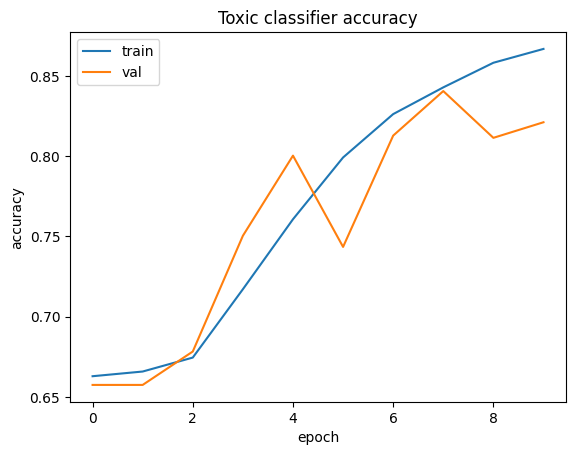

In [110]:
plt.plot(train_accs, label='train')
plt.plot(valid_accs, label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Toxic classifier accuracy')
plt.legend()
plt.show()

В этой модели векторные представления обучаются с нуля. Можно подставить в Embedding слой уже готовые вектора из word2vec/fastext

Обучаем fastext. Можно обучать на размеченных данных, можно использовать другой более объемный корпус (например, вики, который мы использовали выше), а можно и на том и на другом

In [108]:
%%time
ft = gensim.models.FastText(texts + data['norm_text'].values.tolist(), window=10, epochs=10)

CPU times: user 5min 43s, sys: 444 ms, total: 5min 44s
Wall time: 1min 59s


Теперь нам нужно сделать матрицу с векторами. Индексы строчек в этой матрице должны совпадать с индексами слов в словаре.

In [111]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = ft.wv['опрагпллирао']

In [112]:
model_ft = ToxicClassifier(
    vocab_size=len(word2id),
    emb_dim=100,
    max_len=100,
    pretrained_weights=weights,
    freeze_embeddings=True
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=1e-3)

In [ ]:
vocab_size = len(word2id)
model = ToxicClassifier(vocab_size, emb_dim=100, max_len=100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [113]:
num_epochs = 10
train_accs, valid_accs = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    epoch_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    train_loss = epoch_loss / len(train_ds)
    train_acc = correct / total
    train_accs.append(train_acc)

    # validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)

            preds = (torch.sigmoid(logits) > 0.5).float()
            correct += (preds == yb).sum().item()
            total += xb.size(0)

    val_loss /= len(valid_ds)
    val_acc = correct / total
    valid_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, "
          f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

Epoch 1/10 - train loss: 0.6331, train acc: 0.6655, val loss: 0.6209, val acc: 0.6574
Epoch 2/10 - train loss: 0.5972, train acc: 0.6661, val loss: 0.5919, val acc: 0.6588
Epoch 3/10 - train loss: 0.5657, train acc: 0.6793, val loss: 0.5628, val acc: 0.7004
Epoch 4/10 - train loss: 0.5280, train acc: 0.7200, val loss: 0.5278, val acc: 0.7323
Epoch 5/10 - train loss: 0.4862, train acc: 0.7674, val loss: 0.4925, val acc: 0.7656
Epoch 6/10 - train loss: 0.4470, train acc: 0.8017, val loss: 0.4624, val acc: 0.7947
Epoch 7/10 - train loss: 0.4132, train acc: 0.8300, val loss: 0.4402, val acc: 0.7822
Epoch 8/10 - train loss: 0.3857, train acc: 0.8465, val loss: 0.4195, val acc: 0.8225
Epoch 9/10 - train loss: 0.3624, train acc: 0.8595, val loss: 0.4071, val acc: 0.8058
Epoch 10/10 - train loss: 0.3427, train acc: 0.8705, val loss: 0.3929, val acc: 0.8585


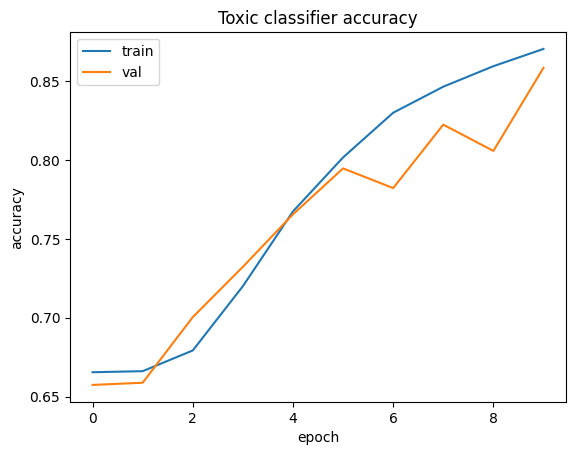

In [114]:
plt.plot(train_accs, label='train')
plt.plot(valid_accs, label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Toxic classifier accuracy')
plt.legend()
plt.show()